# Data Preparation

In [1]:
# Download the dataset
!gdown https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip

# Unzip the dataset
!unzip -q -o dependency_treebank.zip -d dataset

Downloading...
From: https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip
To: /content/dependency_treebank.zip
100% 457k/457k [00:00<00:00, 14.4MB/s]


In [2]:
# Download the GloVe embeddings file
!gdown https://nlp.stanford.edu/data/glove.6B.zip

# Unzip the GloVe embeddings file
!unzip -q -o glove.6B.zip -d embeddings

Downloading...
From: https://nlp.stanford.edu/data/glove.6B.zip
To: /content/glove.6B.zip
100% 862M/862M [02:39<00:00, 5.40MB/s]


In [3]:
# Import the necessary libraries
import os
import re
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

In [4]:
# Utilised functions
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

def get_input(row, embedd_dict):
    global oov_dict

    # Get the Tokens column
    tokens = row['Tokens']

    # Lower case all the tokens
    tokens = [word.lower() for word in tokens]

    # Create the Sentence column by joining the tokens
    sentence = ' '.join(tokens)

    # Create the Features column using GloVe embeddings on the tokens
    features = []

    for word in tokens:
      # If the word is not in the GloVe dictionary (OOV), return random array
        if word not in embedd_dict:
            if word not in oov_dict:
                # Generate random array of size 300 and store in dict
                oov_dict[word] = np.random.rand(300)
            
            features.append(oov_dict[word])

        else:
          features.append(embedd_dict[word])
    
    return sentence, tokens, features

def get_output(row):

    # Get the Tokens column
    tokens = row['Tokens']

    # Lower case all the tokens
    tokens = [word.lower() for word in tokens]

    # Create the Sentence column by joining the tokens
    sentence = ' '.join(tokens)

    # Create the Labels column by label encoding the tags
    labels = []
    for tag in row['Tags']: 
        labels.append(lab_dict[tag])

    return sentence, labels

def one_hot_encode(text):

    # One hot encode the output labels
    encoded_labels = []

    for sentence in text:
        sentence_labels = []

        for label in sentence:
            # Create zeros array of length number of labels
            zeros = np.zeros(len(lab_dict)+1, dtype=int)
            # Index[LABEL] is set to 1
            zeros[int(label)] = 1
            sentence_labels.append(zeros)

        encoded_labels.append(sentence_labels)

    return encoded_labels

In [5]:
# Get the list of files of the dataset
path = '/content/dataset/dependency_treebank/'
files = os.listdir(path)
files = sorted_alphanumeric(files)

li = []
for filename in files:
  
    # Read the file into a dataframe
    data = pd.read_csv(path + filename, sep='\t', header=None)

    tokens = []
    tags = []

    # Iterate through each row and append the tokens and tags to the lists
    for index, row in data.iterrows():
        tokens.append(row[0])
        tags.append(row[1])

        # If the word is a fullstop, start a new set of lists for the tokens and tags
        if row[0] == '.':
            file_num = int(filename[5:8])
            li.append([tokens, tags, file_num])
            tokens = []
            tags = []

# Transform the list of lists into a new dataframe
df = pd.DataFrame(li, columns=['Tokens', 'Tags', 'File'])
print(f'Number of rows: {df.shape[0]}')
df.head()

Number of rows: 3828


,Tokens,Tags,File
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",1
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",1
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",2
3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",3
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",3


In [6]:
# Split the dataset for training, validation and test
train_df = df[df['File'] <= 100]
print(f'Number of training rows: {train_df.shape[0]}')

val_df = df[(df['File'] >= 101) & (df['File'] <= 150)]
print(f'Number of validation rows: {val_df.shape[0]}')

test_df = df[df['File'] >= 151]
print(f'Number of test rows: {test_df.shape[0]}')

Number of training rows: 1936
Number of validation rows: 1256
Number of test rows: 636


In [7]:
# Create the dictionary of GloVe embeddings
embedd_dict = {}
with open('/content/embeddings/glove.6B.300d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], 'float32')
        embedd_dict[word]=vector

In [8]:
# Create the dictionary for POS tag labels
tags = set(np.concatenate(df['Tags']))
lab_dict = {tag:index+1 for index, tag in enumerate(sorted(tags))}
print(lab_dict)

{'#': 1, '$': 2, "''": 3, ',': 4, '-LRB-': 5, '-RRB-': 6, '.': 7, ':': 8, 'CC': 9, 'CD': 10, 'DT': 11, 'EX': 12, 'FW': 13, 'IN': 14, 'JJ': 15, 'JJR': 16, 'JJS': 17, 'LS': 18, 'MD': 19, 'NN': 20, 'NNP': 21, 'NNPS': 22, 'NNS': 23, 'PDT': 24, 'POS': 25, 'PRP': 26, 'PRP$': 27, 'RB': 28, 'RBR': 29, 'RBS': 30, 'RP': 31, 'SYM': 32, 'TO': 33, 'UH': 34, 'VB': 35, 'VBD': 36, 'VBG': 37, 'VBN': 38, 'VBP': 39, 'VBZ': 40, 'WDT': 41, 'WP': 42, 'WP$': 43, 'WRB': 44, '``': 45}


# OOV Terms

In [9]:
# Create the input datasets

# Store already seen OOV words and the generated random vector
# Printing to see test OOV words haven't leaked into training data (should increase after each update)
global oov_dict
oov_dict = {}
update_dict = dict(embedd_dict)
print("Original length of embedd dict: " + str(len(update_dict)))

data = train_df.apply(get_input, embedd_dict=update_dict, axis=1)
X_train = pd.DataFrame(list(data), columns=['Sentence', 'Tokens', 'Features'])
update_dict.update(oov_dict)
print("After processing train set:     " + str(len(update_dict)))

data = val_df.apply(get_input, embedd_dict=update_dict, axis=1)
X_val = pd.DataFrame(list(data), columns=['Sentence', 'Tokens', 'Features'])
update_dict.update(oov_dict)
print("After processing val set:       " + str(len(update_dict)))

data = test_df.apply(get_input, embedd_dict=update_dict, axis=1)
X_test = pd.DataFrame(list(data), columns=['Sentence', 'Tokens', 'Features'])
update_dict.update(oov_dict)
print("After processing test set:      " + str(len(update_dict)))

Original length of embedd dict: 400000
After processing train set:     400359
After processing val set:       400548
After processing test set:      400676


In [10]:
# Preview a sample input dataset
X_train.head()

,Sentence,Tokens,Features
0,"pierre vinken , 61 years old , will join the b...","[pierre, vinken, ,, 61, years, old, ,, will, j...","[[0.28721, 0.12379, 0.067052, -0.0035319, 0.10..."
1,"mr. vinken is chairman of elsevier n.v. , the ...","[mr., vinken, is, chairman, of, elsevier, n.v....","[[-0.071507, -0.42564, 0.28118, -0.21948, -0.4..."
2,"rudolph agnew , 55 years old and former chairm...","[rudolph, agnew, ,, 55, years, old, and, forme...","[[-0.060039, -0.24845, 0.13872, -0.53702, 0.69..."
3,a form of asbestos once used to make kent ciga...,"[a, form, of, asbestos, once, used, to, make, ...","[[-0.29712, 0.094049, -0.096662, -0.344, -0.18..."
4,"the asbestos fiber , crocidolite , is unusuall...","[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[[0.04656, 0.21318, -0.0074364, -0.45854, -0.0..."


In [11]:
# Create the output datasets
data = train_df.apply(get_output, axis=1)
y_train = pd.DataFrame(list(data), columns=['Sentence', 'Labels'])

data = val_df.apply(get_output, axis=1)
y_val = pd.DataFrame(list(data), columns=['Sentence', 'Labels'])

data = test_df.apply(get_output, axis=1)
y_test = pd.DataFrame(list(data), columns=['Sentence', 'Labels'])

In [12]:
# Preview a sample output dataset
y_train.head()

,Sentence,Labels
0,"pierre vinken , 61 years old , will join the b...","[21, 21, 4, 10, 23, 15, 4, 19, 35, 11, 20, 14,..."
1,"mr. vinken is chairman of elsevier n.v. , the ...","[21, 21, 40, 20, 14, 21, 21, 4, 11, 21, 37, 20..."
2,"rudolph agnew , 55 years old and former chairm...","[21, 21, 4, 10, 23, 15, 9, 15, 20, 14, 21, 21,..."
3,a form of asbestos once used to make kent ciga...,"[11, 20, 14, 20, 28, 38, 33, 35, 21, 20, 23, 4..."
4,"the asbestos fiber , crocidolite , is unusuall...","[11, 20, 20, 4, 20, 4, 40, 28, 15, 14, 26, 40,..."


In [13]:
# Pad the sequences to the length of the longest sequence with zeros
max_length = 250
print(f'Maximum length of the sequence: {max_length}')

X_train['Features'] = list(pad_sequences(X_train['Features'], maxlen=max_length, padding='post', dtype='float32'))
y_train['Labels'] = list(pad_sequences(y_train['Labels'], maxlen=max_length, padding='post', dtype='float32'))

X_val['Features'] = list(pad_sequences(X_val['Features'], maxlen=max_length, padding='post', dtype='float32'))
y_val['Labels'] = list(pad_sequences(y_val['Labels'], maxlen=max_length, padding='post', dtype='float32'))

X_test['Features'] = list(pad_sequences(X_test['Features'], maxlen=max_length, padding='post', dtype='float32'))
y_test['Labels'] = list(pad_sequences(y_test['Labels'], maxlen=max_length, padding='post', dtype='float32'))

Maximum length of the sequence: 250


In [14]:
# One hot encode the labels
y_train['Labels'] = one_hot_encode(y_train['Labels'])
y_val['Labels'] = one_hot_encode(y_val['Labels'])
y_test['Labels'] = one_hot_encode(y_test['Labels'])

In [15]:
# Get features and labels for training, validation and test
train_features = np.array(X_train['Features'].to_list(), dtype=np.float)
train_labels = np.array(y_train['Labels'].to_list(), dtype=np.float)

val_features = np.array(X_val['Features'].to_list(), dtype=np.float)
val_labels = np.array(y_val['Labels'].to_list(), dtype=np.float)

test_features = np.array(X_test['Features'].to_list(), dtype=np.float)
test_labels = np.array(y_test['Labels'].to_list(), dtype=np.float)

# Model Architectures

In [16]:
# Install the necessary libraries
!pip install keras_tuner

     |████████████████████████████████| 98 kB 4.1 MB/s 


In [17]:
# Import the necessary libraries
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Bidirectional, GRU, Dense, TimeDistributed, Activation
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch, Objective
from keras.utils.vis_utils import plot_model

In [18]:
# Utilised functions
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = K.argmax(y_true, axis=-1)
        y_pred_class = K.argmax(y_pred, axis=-1)
 
        ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
        matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
        accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

#### Bidirectional LSTM with a Dense layer

In [19]:
# # Define the model architecture
# def baseline_model(hp):
#     model = Sequential()
#     model.add(InputLayer(input_shape=(250, 300)))
#     model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=192, max_value=320, step=64, default=256), return_sequences=True)))
#     model.add(TimeDistributed(Dense(46)))
#     model.add(Activation('softmax'))
#     model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
#                   loss='categorical_crossentropy', metrics=['accuracy', ignore_class_accuracy(0)])
#     return model

# # Hyperparameter optimization using random search
# tuner = RandomSearch(baseline_model, objective=Objective('val_ignore_accuracy', direction='max'), max_trials=3, overwrite=True)
# tuner.search(train_features, train_labels, epochs=2, validation_data=(val_features, val_labels))

In [20]:
# # Plot the model architecture
# plot_model(tuner.get_best_models()[0], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
# # Train the best model for 10 epochs
# best_baseline_model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
# best_baseline_model.fit(train_features, train_labels, epochs=10, validation_data=(val_features, val_labels))
# best_baseline_model.save('models/best_baseline_model.h5')

#### Bidirectional GRU with a Dense layer

In [22]:
# # Define the model architecture
# def gru_model(hp):
#     model = Sequential()
#     model.add(InputLayer(input_shape=(250, 300)))
#     model.add(Bidirectional(GRU(units=hp.Int('units', min_value=192, max_value=320, step=64, default=256), return_sequences=True)))
#     model.add(TimeDistributed(Dense(46)))
#     model.add(Activation('softmax'))
#     model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
#                   loss='categorical_crossentropy', metrics=['accuracy', ignore_class_accuracy(0)])
#     return model

# # Hyperparameter optimization using random search
# tuner = RandomSearch(gru_model, objective=Objective('val_ignore_accuracy', direction='max'), max_trials=3, overwrite=True)
# tuner.search(train_features, train_labels, epochs=2, validation_data=(val_features, val_labels))

In [23]:
# # Plot the model architecture
# plot_model(tuner.get_best_models()[0], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
# # Train the best model for 10 epochs
# best_gru_model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
# best_gru_model.fit(train_features, train_labels, epochs=10, validation_data=(val_features, val_labels))
# best_gru_model.save('models/best_gru_model.h5')

#### Bidirectional LSTM with an additional LSTM layer and a Dense layer



In [25]:
# # Define the model architecture
# def additional_lstm_model(hp):
#     model = Sequential()
#     model.add(InputLayer(input_shape=(250, 300)))
#     model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=192, max_value=320, step=64, default=256), return_sequences=True)))
#     model.add(Bidirectional(LSTM(20, return_sequences=True)))
#     model.add(TimeDistributed(Dense(46)))
#     model.add(Activation('softmax'))
#     model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
#                   loss='categorical_crossentropy', metrics=['accuracy', ignore_class_accuracy(0)])
#     return model

# # Hyperparameter optimization using random search
# tuner = RandomSearch(additional_lstm_model, objective=Objective('val_ignore_accuracy', direction='max'), max_trials=3, overwrite=True)
# tuner.search(train_features, train_labels, epochs=2, validation_data=(val_features, val_labels))

In [26]:
# # Plot the model architecture
# plot_model(tuner.get_best_models()[0], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
# # Train the best model for 10 epochs
# best_additional_lstm_model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
# best_additional_lstm_model.fit(train_features, train_labels, epochs=10, validation_data=(val_features, val_labels))
# best_additional_lstm_model.save('models/best_additional_lstm_model.h5')

#### Bidirectional LSTM with two Dense layers



In [28]:
# # Define the model architecture
# def additional_dense_model(hp):
#     model = Sequential()
#     model.add(InputLayer(input_shape=(250, 300)))
#     model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=192, max_value=320, step=64, default=256), return_sequences=True)))
#     model.add(TimeDistributed(Dense(46)))
#     model.add(TimeDistributed(Dense(46)))
#     model.add(Activation('softmax'))
#     model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), 
#                   loss='categorical_crossentropy', metrics=['accuracy', ignore_class_accuracy(0)])
#     return model

# # Hyperparameter optimization using random search
# tuner = RandomSearch(additional_dense_model, objective=Objective('val_ignore_accuracy', direction='max'), max_trials=3, overwrite=True)
# tuner.search(train_features, train_labels, epochs=2, validation_data=(val_features, val_labels))

In [29]:
# # Plot the model architecture
# plot_model(tuner.get_best_models()[0], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
# # Train the best model for 10 epochs
# best_additional_dense_model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
# best_additional_dense_model.fit(train_features, train_labels, epochs=10, validation_data=(val_features, val_labels))
# best_additional_dense_model.save('models/best_additional_dense_model.h5')

# Model Evaluation

In [31]:
# Download the trained models
!gdown --id 1OLqie9T-iERKa5KeUSwecg5OAZKBUtXn

# Unzip the trained models
!unzip -q -o models.zip -d models

Downloading...
From: https://drive.google.com/uc?id=1OLqie9T-iERKa5KeUSwecg5OAZKBUtXn
To: /content/models.zip
100% 51.8M/51.8M [00:00<00:00, 72.1MB/s]


In [32]:
# Import the necessary libraries
from keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

In [33]:
# Utilised functions
def modify_var(true, pred, indices):
    true = true.argmax(2)
    pred = pred.argmax(2)

    true_nopad = []
    pred_nopad = []

    for t, p in zip(true, pred):
        for i, el in enumerate(t):
            if el !=0 and el not in indices:
                true_nopad.append(el)
                pred_nopad.append(p[i])
    return true_nopad, pred_nopad

In [34]:
# Select the two best models based on the validation ignore accuracy
best_first_model = load_model('/content/models/models/best_baseline_model.h5', 
                              custom_objects={'ignore_class_accuracy': ignore_class_accuracy}, compile=False)

best_second_model = load_model('/content/models/models/best_gru_model.h5', 
                               custom_objects={'ignore_class_accuracy': ignore_class_accuracy}, compile=False)

# Compile the models
best_first_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', ignore_class_accuracy])
best_second_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', ignore_class_accuracy])

In [35]:
# Get the predictions of the best models using the test features
first_pred_labels = best_first_model.predict(test_features)
second_pred_labels = best_second_model.predict(test_features)

In [36]:
# Define the punctuation columns to remove
indices = [lab_dict.get(key) for key in ["$", ",", ".", ":", "#", "``", "''", "-LRB-", "-RRB-"]]
print(indices)

[2, 4, 7, 8, 1, 45, 3, 5, 6]


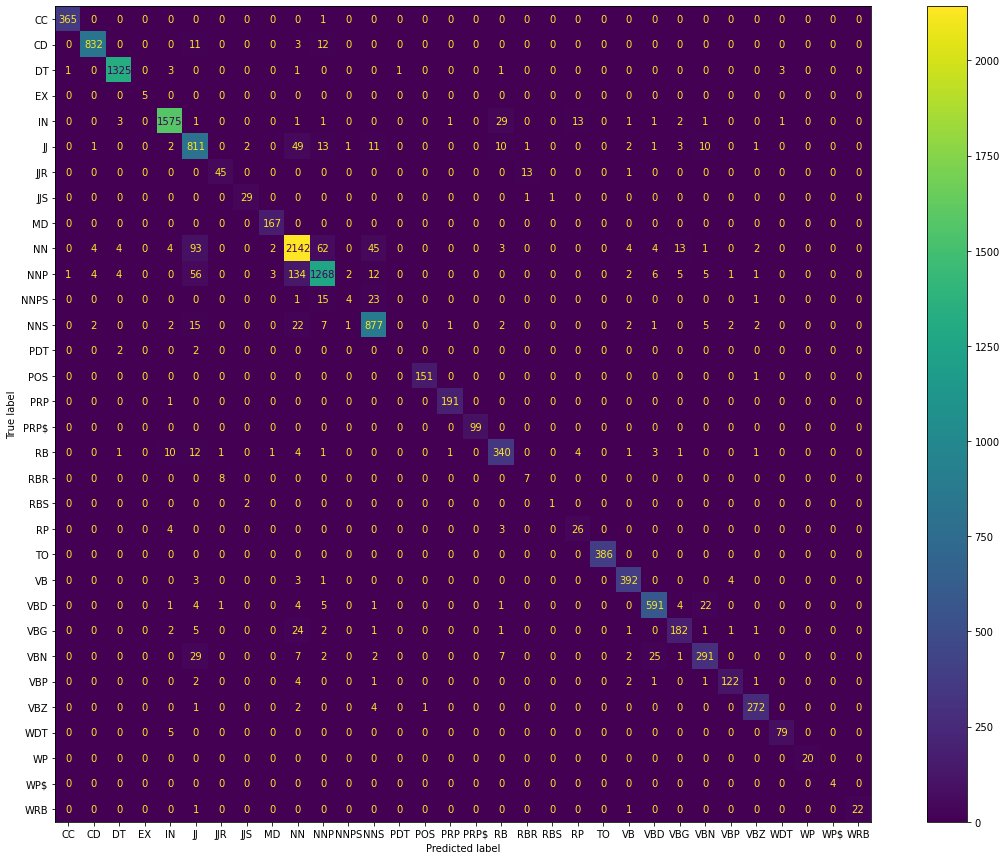

In [37]:
# Print the confusion matrix of the 1st Model
true_var, pred_var = modify_var(test_labels, first_pred_labels, indices)
cm_one = confusion_matrix(true_var, pred_var)
display = ConfusionMatrixDisplay(confusion_matrix=cm_one, display_labels=[t for t, i in lab_dict.items() if i in list(set(test_labels.argmax(2).flatten()) - set(indices) - set([0]))])
fig, ax = plt.subplots(figsize=(20, 15))
display.plot(include_values=True, ax=ax)
plt.show()

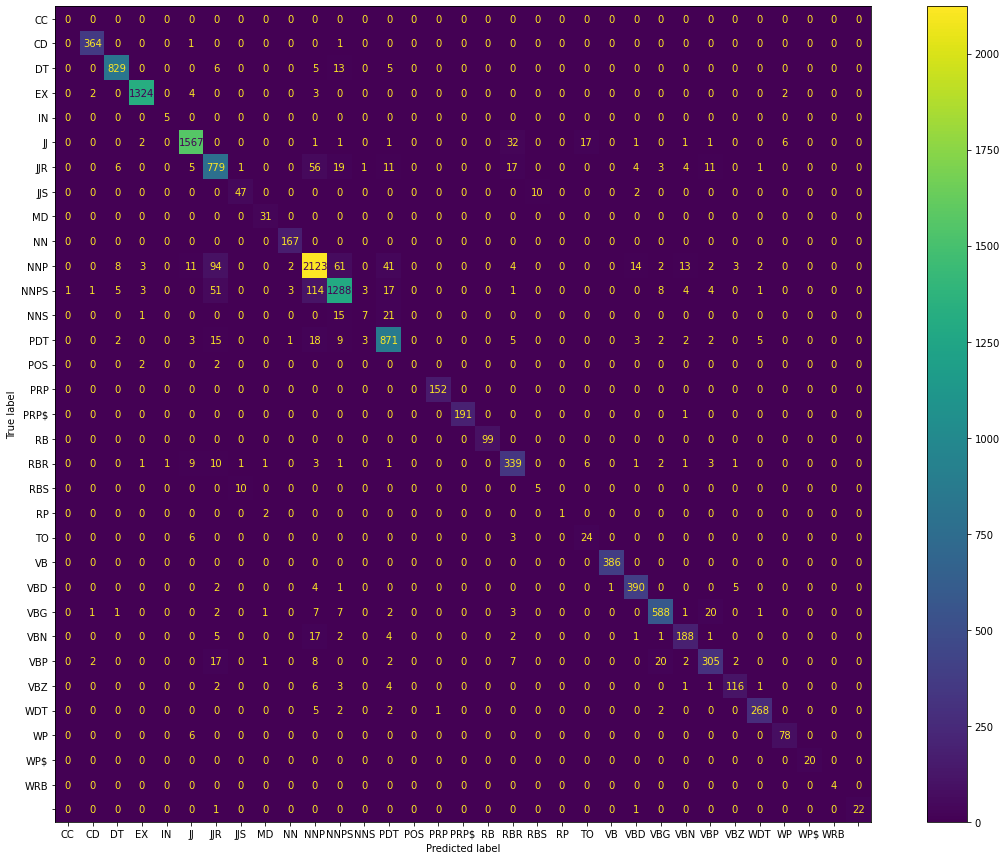

In [38]:
# Print the confusion matrix for the 2nd Model
true_var, pred_var = modify_var(test_labels, second_pred_labels, indices)
cm_two = confusion_matrix(true_var, pred_var)
display = ConfusionMatrixDisplay(confusion_matrix=cm_two, display_labels=[t for t, i in lab_dict.items() if i in list(set(test_labels.argmax(2).flatten()) - set(indices) - set([0]))])
fig, ax = plt.subplots(figsize=(20, 15))
display.plot(include_values=True, ax=ax)
plt.show()

In [39]:
# Calculate the F1 macro score
true_nopad, first_pred_nopad = modify_var(test_labels, first_pred_labels, indices)
true_nopad, second_pred_nopad = modify_var(test_labels, second_pred_labels, indices)
first_f1_macro = f1_score(true_nopad, first_pred_nopad, average='macro', zero_division=1)
second_f1_macro = f1_score(true_nopad, second_pred_nopad, average='macro', zero_division=1)

# Print the performance of the models
print('Best Models Performance')
print(f'\nFirst F1 Macro: {round(first_f1_macro, 3)}')
print(f'\nSecond F1 Macro: {round(second_f1_macro, 3)}')

Best Models Performance

First F1 Macro: 0.843

Second F1 Macro: 0.814
